# 3D image classification from CT scans

**Description:** Train a 3D convolutional neural network to predict presence of pneumonia.

**Note:** To run Google Colab, you will need a Gmail account.

*Note:* Colab GPU usage is limited to approximately 6 hours per day. CPU usage is longer.

## Tasks

* Run the Colab notebook. This should take between 20 minutes on a GPU and an hour on a CPU.
* Check out the source code.
* In this example, the validation accuracy is **73.3%**. An accuracy of 50% is a random guess. Try to increase the validation accuracy above 73% by:
    * running more epochs, such as increasing the patience from 15 to 25 epochs or loading and running a previously saved model;
    * adding more layers to the neural network;
    * changing the hyperparameters;
    * (*optional task*) try something new, such as a new neural network architecture.


## Introduction

This example will show the steps needed to build a 3D convolutional neural network (CNN)
to predict the presence of viral pneumonia in computer tomography (CT) scans. 2D CNNs are
commonly used to process RGB images (3 channels). A 3D CNN is simply the 3D
equivalent: it takes as input a 3D volume or a sequence of 2D frames (e.g. slices in a CT scan),
3D CNNs are a powerful model for learning representations for volumetric data.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

## Setup

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## Downloading the MosMedData: Chest CT Scans with COVID-19 Related Findings

In this example, we use a subset of the
[MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1).
This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.

We will be using the associated radiological findings of the CT scans as labels to build
a classifier to predict presence of viral pneumonia.
Hence, the task is a binary classification problem.

In [2]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
fname1 = os.path.basename(url)  # get "CT-0.zip"

keras.utils.get_file(
    origin=url,
    cache_dir=os.getcwd(),  # the current working directory of the process
    fname=fname1,
)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
fname2 = os.path.basename(url)  # get "CT-23.zip"

keras.utils.get_file(
    origin=url,
    cache_dir=os.getcwd(),  # the current working directory of the process
    fname=fname2,
)

# Make a directory to store the data.
os.makedirs("MosMedData", exist_ok=True)

# Unzip data in the newly created directory.
archive1 = os.path.join(os.getcwd(), "datasets", fname1)
with zipfile.ZipFile(archive1, "r") as z_fp:
    z_fp.extractall("./MosMedData/")

archive2 = os.path.join(os.getcwd(), "datasets", fname2)
with zipfile.ZipFile(archive2, "r") as z_fp:
    z_fp.extractall("./MosMedData/")

1065471431/1065471431 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step
1045162547/1045162547 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step


## Loading data and preprocessing

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`. CT scans store raw voxel
intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset.

**Above 400 are bones** with different radiointensity, so this is used as a higher bound. A threshold
between -1000 and 400 is commonly used to normalize CT scans.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We scale the HU values to be between 0 and 1.
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [3]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """
      Truncate values to range [min, max].
      Normalize the volume to range [0, 1].
    """
    min, max = -1000, 400  # intensity in Hounsfield units (HU)

    # Truncate values to range [min, max].
    volume[volume < min] = min
    volume[volume > max] = max

    # Normalize the volume to range [0, 1].
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


Let's read the paths of the CT scans from the class directories.

In [4]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = []
for x in os.listdir("MosMedData/CT-0"):
    path = os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    normal_scan_paths.append(path)

# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = []
for x in os.listdir("MosMedData/CT-23"):
    path = os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    abnormal_scan_paths.append(path)

print(f"CT scans with normal lung tissue: {len(normal_scan_paths)}")
print(f"CT scans with abnormal lung tissue: {len(abnormal_scan_paths)}")


CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [5]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
i = 70  # split 100 images on 70 and 30
x_train = np.concatenate((abnormal_scans[:i], normal_scans[:i]), axis=0)
y_train = np.concatenate((abnormal_labels[:i], normal_labels[:i]), axis=0)
x_val = np.concatenate((abnormal_scans[i:], normal_scans[i:]), axis=0)
y_val = np.concatenate((abnormal_labels[i:], normal_labels[i:]), axis=0)
print(f"Number of samples in train set are {x_train.shape[0]}\n"
      f"Number of samples in validation set are {x_val.shape[0]}")

Number of samples in train set are 140
Number of samples in validation set are 60


## Data augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

In [6]:
import random

from scipy import ndimage


@tf.function
def data_augmentation(volume):
    """Perform augmentations."""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-15, -10, -5, 5, 10, 15]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        # truncate values to range [0, 1].
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    def random_brightness(volume):
        r = 4 * (tf.random.uniform([]) - 0.5) * 0.05  # random brightness by ±5%
        volume += tf.cast(r, dtype=tf.float32)
        volume = tf.clip_by_value(volume, clip_value_min=0, clip_value_max=1)  # clip to [0,1]
        return volume

    def random_contrast(volume):
        volume = tf.image.random_contrast(volume, 1-0.05, 1+0.05)  # apply small contrast
        volume = tf.clip_by_value(volume, clip_value_min=0, clip_value_max=1)  # clip to [0,1]
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    augmented_volume = tf.numpy_function(random_brightness, [volume], tf.float32)
    augmented_volume = tf.numpy_function(random_contrast, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = data_augmentation(volume)
    # Add a channel
    volume = tf.expand_dims(volume, axis=3)
    # Set the image shape explicitly, otherwise an error will occur:
    #     "ValueError: as_list() is not defined on an unknown TensorShape".
    volume = tf.reshape(volume, (128, 128, 64))
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    # Set the image shape explicitly, otherwise an error will occur:
    #     "ValueError: as_list() is not defined on an unknown TensorShape".
    volume = tf.reshape(volume, (128, 128, 64))
    return volume, label


While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already rescaled to have values between 0 and 1.

In [7]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2

# Augment the data on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
        .map(train_preprocessing)
        .batch(batch_size)
        .prefetch(2)
)

# Rescale only the validation dataset.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
        .map(validation_preprocessing)
        .batch(batch_size)
        .prefetch(2)
)

Visualize an augmented CT scan.

Dimension of the CT scan is: (128, 128, 64)


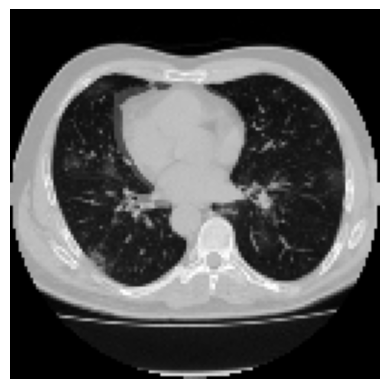

In [8]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)

# image = np.rot90(np.array(image))
# image = np.transpose(image)
im = image[:, :, 30]  # take 31-th slice of the 3D image
im = np.fliplr(im)
plt.axis("off")
plt.imshow(np.squeeze(im), cmap="gray")


Since a CT scan has many slices, let's visualize a montage of the slices.

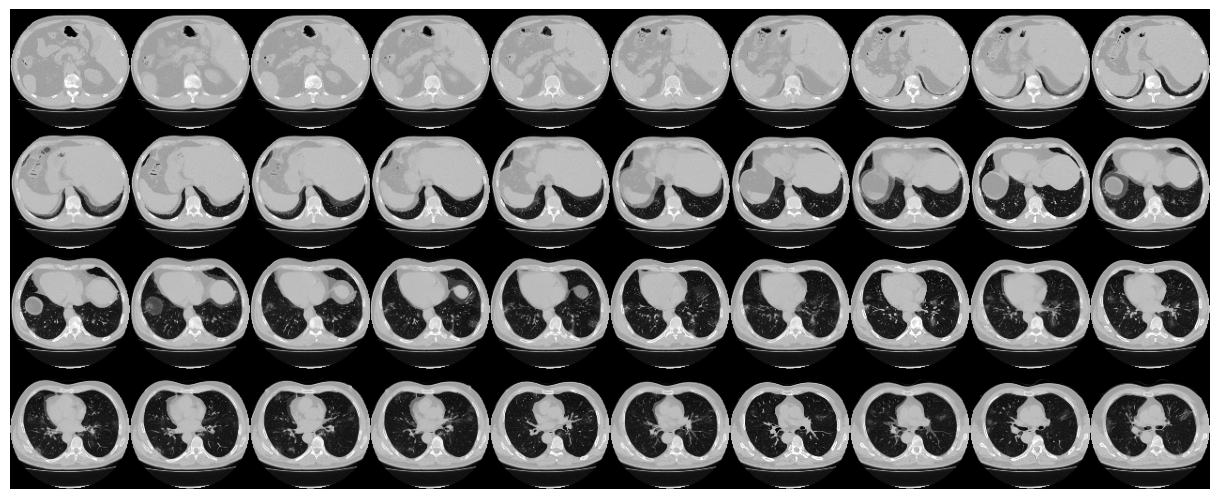

In [9]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for the first 40 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

## Define a convolutional neural network for 3D images

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [10]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 126, 126, 62,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 63, 63, 31, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 31, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 61, 61, 29, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 30, 30, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 28, 28, 12,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 14, 14, 6, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 6, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 12, 4, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 6, 6, 2, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 2, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

## Train model

In [11]:
fname = '3d_image_classification.keras'  # model name

# Load best weights, if necessary
if os.path.exists(fname):
    model.load_weights(fname)

In [16]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True,
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['acc'],  # map to tf.keras.metrics.BinaryAccuracy
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    fname,
    save_best_only=True,
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_acc",
    patience=15,
)

# Train the model, doing validation at the end of each epoch
epochs = 100  # maximum number of training epochs
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
70/70 - 39s - 555ms/step - acc: 0.7143 - loss: 0.5274 - val_acc: 0.6333 - val_loss: 0.7040
Epoch 2/100
70/70 - 29s - 420ms/step - acc: 0.7857 - loss: 0.4879 - val_acc: 0.6000 - val_loss: 1.1414
Epoch 3/100
70/70 - 27s - 385ms/step - acc: 0.8071 - loss: 0.4240 - val_acc: 0.6333 - val_loss: 0.6200
Epoch 4/100
70/70 - 40s - 576ms/step - acc: 0.8429 - loss: 0.4421 - val_acc: 0.7000 - val_loss: 0.6417
Epoch 5/100
70/70 - 27s - 381ms/step - acc: 0.7786 - loss: 0.3827 - val_acc: 0.6833 - val_loss: 0.5720
Epoch 6/100
70/70 - 41s - 582ms/step - acc: 0.8786 - loss: 0.3096 - val_acc: 0.6167 - val_loss: 0.7230
Epoch 7/100
70/70 - 27s - 380ms/step - acc: 0.8286 - loss: 0.3741 - val_acc: 0.7000 - val_loss: 0.6046
Epoch 8/100
70/70 - 40s - 576ms/step - acc: 0.8000 - loss: 0.4305 - val_acc: 0.6833 - val_loss: 0.8425
Epoch 9/100
70/70 - 41s - 591ms/step - acc: 0.8500 - loss: 0.3608 - val_acc: 0.6333 - val_loss: 0.8276
Epoch 10/100
70/70 - 27s - 381ms/step - acc: 0.8429 - loss: 0.3087 - val_

It is important to note that the number of samples is very small (only 200) and we don't specify a random seed. As such, you can expect significant variance in the results. The entire dataset consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the entire dataset, an accuracy of 83% was achieved. A variability in classification performance of 6–7% is observed both for the entire dataset and for 200 images.

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

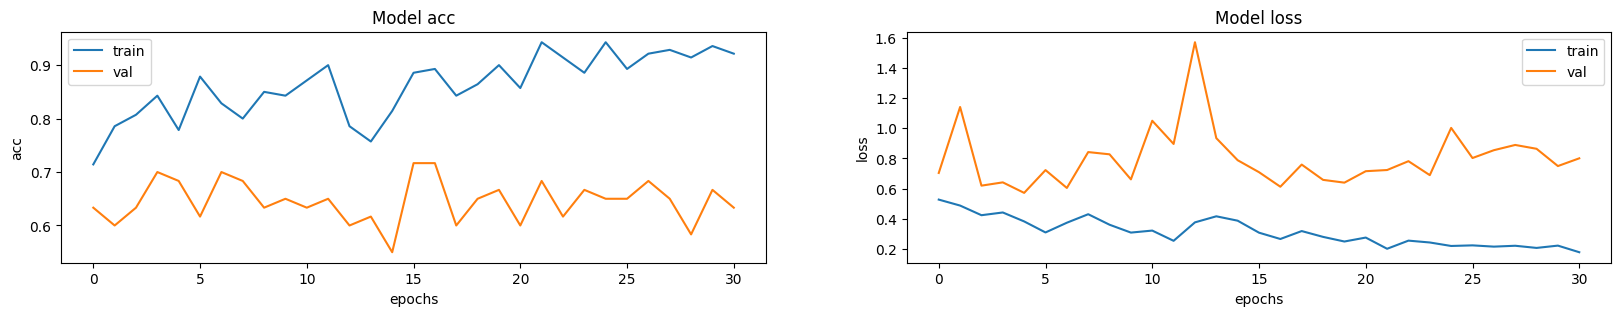

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Make predictions on a single CT scan

In [18]:
# Load best weights.
i = 3
model.load_weights(fname)
prediction = model.predict(np.expand_dims(x_val[i], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(f"This model is {(100 * score):.2f}% confident that CT scan {i} is '{name}'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
This model is 3.78% confident that CT scan 3 is 'normal'
This model is 96.22% confident that CT scan 3 is 'abnormal'


## Testing the trained model

In [19]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(validation_dataset, verbose=0)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {(accuracy * 100):.2f}%")

Validation Loss: 0.5720006227493286
Validation Accuracy: 68.33%
